# UN General Debates

In [1]:
%matplotlib inline
import string
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import textatistic
import seaborn as sbn
from altair import Chart, X, Y, Color, Scale
import altair as alt
from vega_datasets import data
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords 
matplotlib.style.use('ggplot')

## Reading List

* Reshaping data with pandas [Nicely covered here](https://jakevdp.github.io/PythonDataScienceHandbook/)
* [Word Clouds](https://www.datacamp.com/community/tutorials/wordcloud-python)
* [Text complexity measures](http://www.erinhengel.com/software/textatistic/)
* [Tidy Data in Python](http://www.jeannicholashould.com/tidy-data-in-python.html)
* the original [Tidy Data paper](http://vita.had.co.nz/papers/tidy-data.pdf) by Hadley Wickham

## Exploratory Questions

1. How many speeches were given each year?
2. Make a bar graph of the number of speeches each year
3. Which country and what year has given the longest speech (by number of words)
4. Which country has spoken the most times?
5. Which country has spoken the least times?
6. Make a graph to illustrate the distribution of the number of times each country has spoken
7. What were the 25 most commonly used words in the 1970 session?
8. What were the 25 most commonly used words in the 2015 session?

In [2]:
undf = pd.read_csv('Data/un-general-debates.csv')

In [3]:
len(undf)

7507

In [4]:
undf.sort_values('year', ascending=False).head()

,session,year,country,text
5543,70,2015,KNA,It is indeed an honour for me to address this ...
5524,70,2015,KOR,I would first like to congratulate the United ...
5522,70,2015,ARE,It is my pleasure to congratulate Mr. Mogens L...
5521,70,2015,BHS,"I bring you, Sir, and the Assembly warm frater..."
5520,70,2015,ISL,The world has changed enormously since the est...


As you can see the data frame is relatively simple.  It consists of a session number, year, country code and text.  Most of the text is hidden because Pandas doesn't want to make the notebook with unreadably long text strings.  In reality most of the texts are very lengthy!  If you want to see the entire string you can update Jupyter's `max_colwidth` option to see it all.  You'll probably want to set it back because as you can see in the following example looking at the entire thing is largely useless.

In [5]:
pd.set_option('display.max_colwidth', -1)
print(undf[(undf.year == 1970) & (undf.country == 'USA')].text)
pd.set_option('display.max_colwidth', 50)

161    1.\t It is my privilege to extend to you once again the warm congratulations of the United States delegation on your election to the Presidency of the twenty-fifth session of the General Assembly. Your country has few peers in the contributions it has made to the work of this Organization. Your father was a leader in the League of Nations, and now, in this session of the General Assembly, you are adding a new chapter in the family tradition. In the United Nations community we have long known you as an able spokesman of your country, as a participant in the life of the United Nations from its very beginning and an authority on the Charter, as a leading scholar and practitioner in international law, and as one whose personal outlook is strongly humanitarian and imbued with hope and determination for a better future. We are indeed fortunate to have you to lead us in this session devoted to the strengthening and improvement of the United Nations.\n2.\tDuring this session we shall co

The number of speeches each year will require us to use our new tool of grouping data.  This is the split-apply-combine pattern that you may have learned about previously but is so commonly used in data science that Pandas makes it pretty easy for us.

In [6]:
by_year = undf.groupby('year', as_index=False)['text'].count()
by_year.head()

,year,text
0,1970,70
1,1971,116
2,1972,125
3,1973,120
4,1974,129


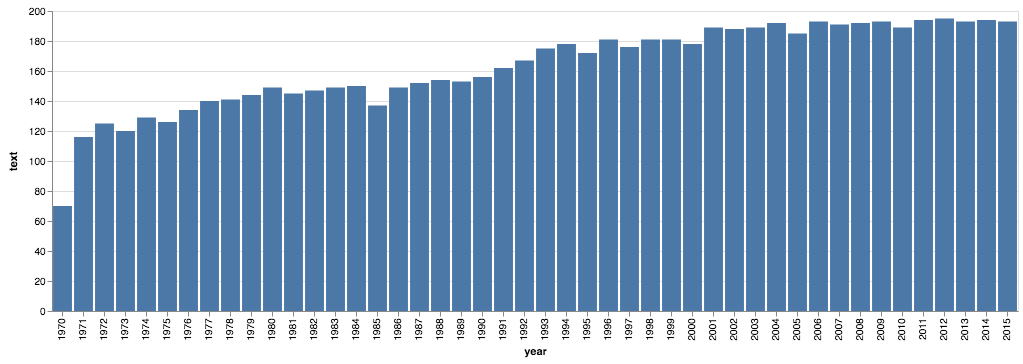

In [7]:
alt.Chart(by_year).mark_bar().encode(x='year:N',y='text')

In [8]:
by_country = undf.groupby('country',as_index=False)['text'].count()
by_country.head()

,country,text
0,AFG,45
1,AGO,38
2,ALB,46
3,AND,22
4,ARE,44


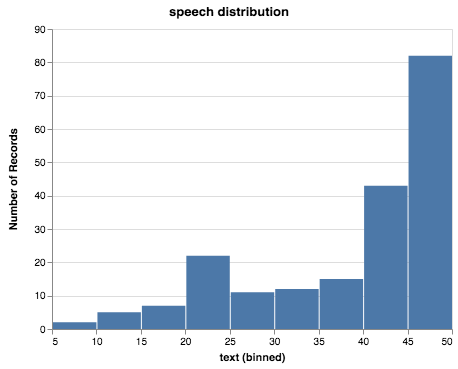

In [9]:
alt.Chart(by_country,title='speech distribution').mark_bar().encode(x=alt.X('text',bin=True),y='count()')

In [10]:
by_country.loc[by_country.text.idxmax()]

country    ALB
text        46
Name: 2, dtype: object

In [11]:
by_country.loc[by_country.text.idxmin()]

country    EU
text        5
Name: 58, dtype: object

Those answers are not very satisfactory as we can only guess as to which country ALB or EU might be.  Somewhat distressingly we see that in one case the three digit code is used and in another a two digit code.  We will want to augment this data using our world factbook data or the data we scraped.  I have a complete table ready for you to load so you don't have to scrape it again.

In [12]:
#c_codes = pd.read_csv('Data/country_codes.csv')
#c_codes.head()

## OH NO What the heck!!

Unicode errors can be a huge pain, but are a fact of life for anyone dealing with data from multiple sources.  In this case we can use the unix file command to get a bit more information:

    $ file -I country_codes.csv                      
    country_codes.csv: text/plain; charset=iso-8859-1
    
Now that we know how the file is encoded we can read it easily    

In [13]:
c_codes = pd.read_csv('Data/country_codes.csv', encoding='iso-8859-1')
c_codes.head()

,country,code_2,code_3,country_code,iso_3166_2,continent,sub_region,region_code,sub_region_code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150.0,154.0
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150.0,39.0
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,2.0,15.0
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,9.0,61.0


This data frame has a lot of information and we can add all or just a bit of it to our united nations dataframe using Pandas' `merge` method. 

Before we merge lets clean up the column names on the undf data frame and rename country to code_3 to be consistent with the above.

In [14]:
undf.columns = ['session', 'year', 'code_3', 'text']
undf.head()


,session,year,code_3,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


Now we can merge our two data frames!  We will keep all the columns from the original undf data frame  and add country, continent, and subregion from the c_codes data frame.  We will merge the two data frames on the code_3 column.  That is for every row in undf we will look for a row in the c_codes data frame where the values for code_3 match.  Pandas will then add the rest of the columns from the matching row in c_codes  to the current row in undf.  

**Dramatic foreshadowing** In the c_codes data frame code_3 is the 'primary key' as no two rows will have the same value for code_3.  In the undf data frame code_3 is a 'Foreign key' as we use it to lookup additional information in a table where code_3 is a primary key.   More on this when we study SQL queries.

In [15]:
undfe = undf.merge(c_codes[['code_3', 'country', 'continent', 'sub_region']])
undfe.head()

,session,year,code_3,text,country,continent,sub_region
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,Maldives,Asia,Southern Asia
1,68,2013,MDV,I wish to begin by \nextending my heartfelt co...,Maldives,Asia,Southern Asia
2,63,2008,MDV,I am delivering this \nstatement on behalf of ...,Maldives,Asia,Southern Asia
3,46,1991,MDV,﻿Allow me at the outset on behalf of the deleg...,Maldives,Asia,Southern Asia
4,41,1986,MDV,It is indeed a pleasure for me and all the mem...,Maldives,Asia,Southern Asia


In [16]:
undfe[undf.code_3 == 'EU ']

/Users/bradleymiller/.local/share/virtualenvs/httlads--V2x4wK-/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,session,year,code_3,text,country,continent,sub_region


Wait! What?  what happened to EU?!!  Why did it dissappear after the merge?  What else may have dissappeared?  The reason the EU dissappeared is that it is not in the c_codes data frame, and as you may recall the merge function does the equivalent of a set intersection.  That is the key must be in BOTH data frames in order for it to be in the result.  We can do our merge using an outer join to preserve the data and then see which countries have no text and which texts have no country name.


In [66]:
undfe = undf.merge(c_codes[['code_3', 'country', 'continent', 'sub_region']], how='outer')
undfe.head()

,session,year,code_3,text,text_len,country,continent,sub_region
0,44.0,1989.0,MDV,﻿It is indeed a pleasure for me and the member...,3011.0,Maldives,Asia,Southern Asia
1,68.0,2013.0,MDV,I wish to begin by \nextending my heartfelt co...,2252.0,Maldives,Asia,Southern Asia
2,63.0,2008.0,MDV,I am delivering this \nstatement on behalf of ...,1909.0,Maldives,Asia,Southern Asia
3,46.0,1991.0,MDV,﻿Allow me at the outset on behalf of the deleg...,2330.0,Maldives,Asia,Southern Asia
4,41.0,1986.0,MDV,It is indeed a pleasure for me and all the mem...,2630.0,Maldives,Asia,Southern Asia


Now lets see which country names are not filled in.

In [71]:
undfe[undfe.country.isna()].code_3.unique()

array(['YDYE', 'CSK', 'YUG', 'DDR', 'EU'], dtype=object)

In [72]:
undfe[undfe.text.isna()].code_3.unique()

array(['ALA', 'ASM', 'AIA', 'ATA', 'ABW', 'BMU', 'BES', 'BVT', 'IOT',
       'CYM', 'CXR', 'CCK', 'COK', 'CUW', 'FLK', 'FRO', 'GUF', 'PYF',
       'ATF', 'GIB', 'GRL', 'GLP', 'GUM', 'GGY', 'HMD', 'HKG', 'IMN',
       'JEY', 'MAC', 'MTQ', 'MYT', 'MSR', 'NCL', 'NIU', 'NFK', 'MNP',
       'PCN', 'PRI', 'REU', 'BLM', 'SHN', 'MAF', 'SPM', 'SRB', 'SXM',
       'SGS', 'SJM', 'TWN', 'TKL', 'TCA', 'UMI', 'VGB', 'VIR', 'WLF',
       'ESH'], dtype=object)

In [74]:
undfe[undfe.text.isna()].country.unique()

array(['Åland Islands', 'American Samoa', 'Anguilla', 'Antarctica',
       'Aruba', 'Bermuda', 'Bonaire, Sint Eustatius and Saba',
       'Bouvet Island', 'British Indian Ocean Territory',
       'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands',
       'Cook Islands', 'Curaçao', 'Falkland Islands (Malvinas)',
       'Faroe Islands', 'French Guiana', 'French Polynesia',
       'French Southern Territories', 'Gibraltar', 'Greenland',
       'Guadeloupe', 'Guam', 'Guernsey',
       'Heard Island and McDonald Islands', 'Hong Kong', 'Isle of Man',
       'Jersey', 'Macao', 'Martinique', 'Mayotte', 'Montserrat',
       'New Caledonia', 'Niue', 'Norfolk Island',
       'Northern Mariana Islands', 'Pitcairn', 'Puerto Rico', 'Réunion',
       'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha',
       'Saint Martin (French part)', 'Saint Pierre and Miquelon',
       'Serbia', 'Sint Maarten (Dutch part)',
       'South Georgia and the South Sandwich Islands',
      

Do some research and fill in the country names for YDYE, CSK, YUG, DDR, and EU by hand.

In [75]:
undfe.loc[undfe.code_3 == 'EU', 'country'] = 'European Union'

In [17]:
by_country = undfe.groupby('country',as_index=False)['text'].count()
by_country.loc[by_country.text.idxmin()]

country    South Sudan
text                 5
Name: 161, dtype: object

In [18]:
c_codes[c_codes.code_2 == 'EU']

,country,code_2,code_3,country_code,iso_3166_2,continent,sub_region,region_code,sub_region_code


I suspect that EU is the European Union which has a place in the UN but is not a country.  So OK, South Sudan has only spoken 5 times.  Why is that? There is a very logical explanation, but it only makes you want to check out the 5 or 10 countries that have spoken the least.  What are they?

Ok, but why did EU seem to dissappear?  When we do a merge if the key is missing then the row is not included in the final result.


In [19]:
len(undfe)

7406

In [20]:
len(undf.code_3.unique())

199

In [21]:
len(undfe.code_3.unique())

194

In [22]:
set(undf.code_3.unique()) - set(undfe.code_3.unique())

{'CSK', 'DDR', 'EU', 'YDYE', 'YUG'}

Can you figure out what each of the above stand for?  Why are they not in the list I gave you?

At this point you may want to edit the csv file and add the data for these countries to the file.  Then you can rerun the whole notebook and we will not lose as much data.

Before we tackle most common and least common words we need to understand a couple of things about text processing.  First we are going to want to clean up our text, and second we need to learn about stop words.  If you think about it for a minute you can probably answer the question of the most used words already they will be words like 'a', 'an', 'the', 'and' etc.  These words are pretty useless if we are trying to extract some meaning from long texts.  Our initial list of cleaening tasks is as follows:

1. Convert all text to lower case
2. Remove all punctuation
3. Break the string into a list of words
4. Remove stop words from the list


In [23]:
speeches_1970 = undf[undf.year == 1970].copy()


In [24]:
speeches_1970['text'] = speeches_1970.text.apply(lambda x: x.lower())

In [25]:
speeches_1970['text'] = speeches_1970.text.apply(lambda x: x.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))))


In [26]:
speeches_1970['word_list'] = speeches_1970.text.apply(nltk.word_tokenize)

In [27]:
from collections import Counter
c = Counter(speeches_1970.word_list.sum())

In [28]:
c.most_common(10)

[('the', 25077),
 ('of', 16265),
 ('and', 9224),
 ('to', 9134),
 ('in', 6668),
 ('a', 4530),
 ('that', 3919),
 ('is', 3322),
 ('for', 2563),
 ('which', 2471)]

In [29]:
c.most_common()[-10:]

[('shabby', 1),
 ('predatory', 1),
 ('siphoned', 1),
 ('crop', 1),
 ('outflow', 1),
 ('ashes', 1),
 ('pr', 1),
 ('bystander', 1),
 ('antiimperialist', 1),
 ('earn', 1)]


    LookupError: 
    **********************************************************************
      Resource stopwords not found.
      Please use the NLTK Downloader to obtain the resource:

      >>> import nltk
      >>> nltk.download('stopwords')

      Searched in:
        - '/Users/bradleymiller/nltk_data'
        - '/usr/share/nltk_data'
        - '/usr/local/share/nltk_data'
        - '/usr/lib/nltk_data'
        - '/usr/local/lib/nltk_data'
        - '/Users/bradleymiller/.local/share/virtualenvs/httlads--V2x4wK-/bin/../nltk_data'
        - '/Users/bradleymiller/.local/share/virtualenvs/httlads--V2x4wK-/bin/../share/nltk_data'
        - '/Users/bradleymiller/.local/share/virtualenvs/httlads--V2x4wK-/bin/../lib/nltk_data'
    **********************************************************************


In [30]:
sw = set(stopwords.words('english'))
len(sw)

179

In [31]:
speeches_1970['word_list'] = speeches_1970.word_list.apply(lambda x: [y for y in x if y not in sw])

In [32]:
c = Counter(speeches_1970.word_list.sum())

In [33]:
c.most_common(25)

[('nations', 1997),
 ('united', 1996),
 ('international', 1251),
 ('world', 1101),
 ('peace', 1019),
 ('countries', 908),
 ('states', 897),
 ('organization', 763),
 ('would', 677),
 ('people', 649),
 ('development', 649),
 ('security', 594),
 ('general', 571),
 ('peoples', 567),
 ('assembly', 552),
 ('charter', 551),
 ('government', 544),
 ('one', 535),
 ('must', 474),
 ('also', 454),
 ('economic', 450),
 ('us', 401),
 ('years', 392),
 ('time', 371),
 ('great', 369)]

In [34]:
c.most_common()[-25:]

[('reliably', 1),
 ('polish', 1),
 ('sqon', 1),
 ('ultra', 1),
 ('nonapplicability', 1),
 ('statutory', 1),
 ('2391', 1),
 ('renovation', 1),
 ('russia', 1),
 ('gbout', 1),
 ('•', 1),
 ('prediction', 1),
 ('oceania', 1),
 ('fat', 1),
 ('1848th', 1),
 ('shabby', 1),
 ('predatory', 1),
 ('siphoned', 1),
 ('crop', 1),
 ('outflow', 1),
 ('ashes', 1),
 ('pr', 1),
 ('bystander', 1),
 ('antiimperialist', 1),
 ('earn', 1)]

### Practice

Redo the analysis of the most common and least common words for 2015

Normalize the data so that you are looking at percentages not raw counts.

Build a graph to compare 1970 and 2015

Look at the documentation for the wordcloud package.  Make a word cloud for both 1970 and 2015


## Research Questions

1. What is the average word count per speech?
1. How does that average compare across all of the countries?
2. What is the average sentence length per speech
3. Using the Fogg or xxx index compute the reading complexity for each speech
3. Is there any correlation between the Fogg index for a country and the GDP or literacy rate?
4. Make a graph showing the distribution of each of the above measures
5. Find or create a list of topics that the UN might discuss and debate make a graph to show how often these topics were mentioned.
6. The five permanent members of the UN security council are sec_council = ['USA', 'RUS', 'GBR', 'FRA', 'CHN']
7. Make a graph of the frequency of topics and how often they are discussed by those countries.
8. Make a graph to show the frequency with which various topics are discussed over the years.  for example, peace is consistently a popular word as is freedom and human rights.  what about HIV or terrorism or global warming.  Compare two phrases like 'global warming' and 'climate change' 
9. When did the internet become a popular topic?

In [35]:
topics = [' nuclear', ' weapons', ' nuclear weapons', ' chemical weapons', 
          ' biological weapons', ' mass destruction', ' peace', ' war',
          ' nuclear war', ' civil war', ' terror', ' genocide', ' holocaust',
          ' water', ' famine', ' disease', ' hiv', ' aids', ' malaria', ' cancer',
          ' poverty', ' human rights', ' abortion', ' refugee', ' immigration',
          ' equality', ' democracy', ' freedom', ' sovereignty', ' dictator',
          ' totalitarian', ' vote', ' energy', ' oil',  ' coal',  ' income',
          ' economy', ' growth', ' inflation', ' interest rate', ' security',
          ' cyber', ' trade', ' inequality', ' pollution', ' global warming',
          ' hunger', ' education', ' health', ' sanitation', ' infrastructure',
          ' virus', ' regulation', ' food', ' nutrition', ' transportation',
          ' violence', ' agriculture', ' diplomatic', ' drugs', ' obesity',
          ' islam', ' housing', ' sustainable', 'nuclear energy']

In [36]:
undf.head()

,session,year,code_3,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [37]:
year_summ = undf.groupby('year', as_index=False)['text'].sum()

In [38]:
year_summ.head()

,year,text
0,1970,126.\t In this anniversary year the General As...
1,1971,"83.\t Mr. President, the first words of my del..."
2,1972,Since the twenty-sixth session of the General ...
3,1973,﻿1.\tIt is a great pleasure for me to congratu...
4,1974,"Mr. President, first I should like to extend m..."


In [39]:
year_summ['gw'] = year_summ.text.str.count('global warming')
year_summ['cc'] = year_summ.text.str.count('climate change')
year_summ

,year,text,gw,cc
0,1970,126.\t In this anniversary year the General As...,0,0
1,1971,"83.\t Mr. President, the first words of my del...",0,0
2,1972,Since the twenty-sixth session of the General ...,0,0
3,1973,﻿1.\tIt is a great pleasure for me to congratu...,0,1
4,1974,"Mr. President, first I should like to extend m...",0,0
5,1975,"104.\t Mr. President, on behalf of the delegat...",0,0
6,1976,Allow me first to say how pleased I am to see ...,0,0
7,1977,"﻿ \n1.\t'O praise the Lord, all ye nations: pr...",0,0
8,1978,﻿210.\tI am particularly happy to be able in m...,0,0
9,1979,﻿My delegation is pleased to convey to the rep...,0,0


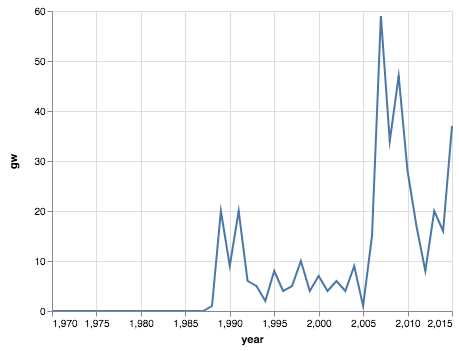

In [40]:
alt.Chart(year_summ[['year', 'gw', 'cc']]).mark_line().encode(x='year',y='gw')

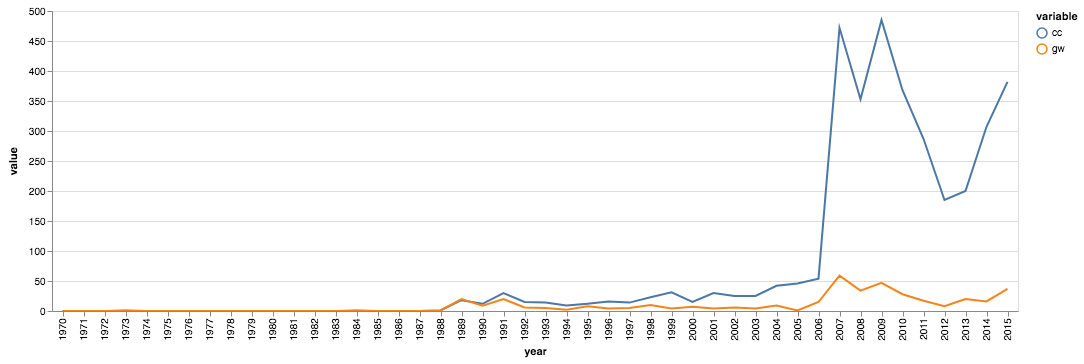

In [42]:
alt.Chart(year_summ[['year', 'gw', 'cc']].melt(id_vars='year', value_vars=['cc','gw'])
         ).mark_line().encode(x='year:O',y='value', color='variable')

Fascinating!  Until the late 80's neither global warming or climate change and were mentioned with relatively close to the same frequency until 2006 when climate change became a huge topic.  This raises all kinds of interesting questions.  Which countries were talking about these topics and when?  This is exactly the kind of thing that happens in data science.  One question or the visualization of one or more items often leads to further and even more interesting questions.

In [43]:
year_summ['pollution'] = year_summ.text.str.count('pollution')

In [44]:
year_summ['terror'] = year_summ.text.str.count('terror')

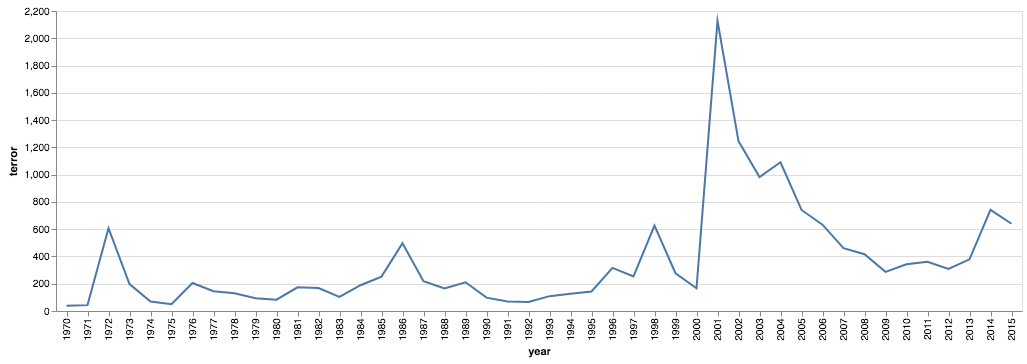

In [45]:
alt.Chart(year_summ[['year','terror']]).mark_line().encode(x='year:O', y='terror')

In [46]:
import numpy as np
nrows, ncols = 100000, 100
rng = np.random.RandomState(43)
df1, df2, df3, df4 = (pd.DataFrame(rng.rand(nrows,ncols)) for i in range(4))

In [49]:
%timeit df1 + df2 + df3 + df4

84.9 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
%timeit pd.eval('df1 + df2 + df3 + df4')

38.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
undf['text_len'] = undf.text.map(lambda x : len(x.split()))

In [57]:
undf.head()

,session,year,code_3,text,text_len
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,3011
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",2727
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",4860
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,2711
4,44,1989,ZWE,﻿I should like at the outset to express my del...,4551


In [62]:
undf.groupby('code_3', as_index=False)['text_len'].mean().head()

,code_3,text_len
0,AFG,3014.444444
1,AGO,2645.315789
2,ALB,3482.369565
3,AND,2153.045455
4,ARE,2313.500000


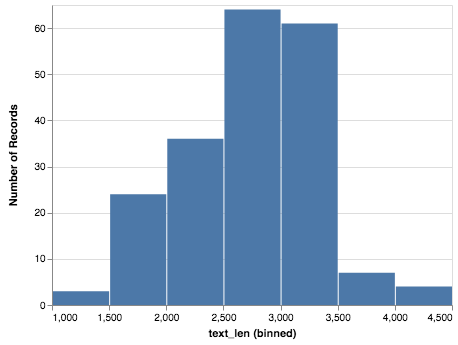

In [63]:
alt.Chart(undf.groupby('code_3', as_index=False)['text_len'].mean()).mark_bar().encode(
alt.X('text_len', bin=True), y='count()')

In [64]:
undf.groupby('code_3', as_index=False)['text_len'].mean().sort_values('text_len').head()

,code_3,text_len
25,BRN,1146.870968
186,UZB,1484.700000
176,TON,1496.466667
141,PLW,1517.944444
103,LIE,1538.115385


In [65]:
undf.groupby('code_3', as_index=False)['text_len'].mean().sort_values('text_len').tail()

,code_3,text_len
53,EGY,3981.590909
101,LBY,4074.477273
42,CUB,4100.217391
81,IRL,4284.466667
150,RUS,4400.666667
